### **4 Feature engineering of the target variable and model testing**
Our next step in the process of building a model to predict if an item is going to be returned or not, will include feature engineering of the categorical variables and building the base models.
Our dataset contains numerous categorical variables, which depending on the model we use, must be encoded in a specific way in order for the model to be able to interpret them. Furthermore, some of the categorical variables such as **item_id**, **user_id**, **brand_id** possess a large number of unique values or in other words said these variables have high **cardinality**. In order to make use of them we will use a technique called **leave one out encoding"**, which in its essence is a technique to reduce the cardinality of the categorical variables by replacing all unique values of a variable with its **target mean**.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = "Dark2")
my_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
pd.set_option('display.max_columns', None)
from itertools import chain, combinations

In [8]:
import importlib
import Model_functions
importlib.reload(Model_functions)
from Model_functions import Model_class 

In [7]:
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import mean_absolute_error
# from catboost import CatBoostClassifier, Pool
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# import tensorflow as tensorflow
# from lightgbm import LGBMClassifier
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("df_processed.csv")
df

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,3,209.8,69.93,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,3,209.8,69.93,2,1,2,1,1,2,2,1,2,1,1,2,1,2,2,1,1,2,1,2,1,2
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,3,209.8,69.93,2,1,2,1,1,2,2,1,2,1,1,2,1,2,2,1,1,2,1,2,1,2
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89,0,4,4,4,2,6,14,14,1,39.9,39.90,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411,0,4,4,4,2,6,14,14,3,249.7,83.23,1,2,2,1,2,1,1,2,1,2,1,2,2,1,1,2,1,2,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,9,748.2,83.13,1,8,5,4,3,6,4,5,1,8,1,8,3,6,4,5,3,6,1,8,3,6
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,9,748.2,83.13,2,7,5,4,3,6,4,5,2,7,2,7,3,6,4,5,3,6,2,7,3,6
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35,6,3,4,5,28,2,17,18,1,79.9,79.90,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0,6,3,4,5,28,2,17,18,2,119.8,59.90,2,0,2,0,1,1,2,0,2,0,1,1,1,1,2,0,1,1,1,1,1,1


In [4]:
low_cardinality_cat_cols = ["size","item_color","user_title","user_state"]
high_cardinality_cat_cols = ["item_id","brand_id","user_id"]
cat_cols = low_cardinality_cat_cols + high_cardinality_cat_cols
# size of the known dataset
k = max(df["order_item_id"])-1

#### **4.2 Defining the models**

As base models, we are going to use **LightGBM**, **XGBoost**, **CatBoost** and **Neural Network**. **LightGBM** and **CatBoost** can handle categorical variables as long as they are of type "category" **Xgboost** and **Neural Networks** do not support them natively, thus we need to encode them.

We are going to divide our dataset into two sets: **train** with months 11 months spanning from April to February and **test** containing the transactions in March. We will use the **train** set to build our model and the **test** set to evaluate its performance. It is important to split the data "manually" and not use a randomized train test split because we want to avoid target leakage and prevent overfitting of the model since every single item is a part of specific order and many customers are one-time buyers. If we split the data randomly, we will mix the items in the train and test sets in a way that violates our assumptions, and end up with a model that is not able to generalize to new data. For example, if an item in the test set was bought from a one-time buyer, that has returned all his items, then the model will be able to predict that he will also most likely return the item as well.

#### **4.3 Fitting the models**
In this subsection we will fit the models and evaluate their performance using the Mean Absolute Error (MAE) as a metric. 

In [5]:
# Instantiate the model class
Model = Model_class(df)

In [6]:
# Split the data into train and test sets
df_train,df_test, df_valid = Model.split_data(False)
# Encode the categorical variables using leave-one-out encoding
df_train_encoded,df_test_encoded,encoder = Model.LOE_Encoder(df_train,df_test, cat_cols,0.1,True)
# Encode the categorical variables using leave-one-out encoding without dropping the categorical columns
df_train_encoded_whole,df_test_encoded_whole,encoder = Model.LOE_Encoder(df_train,df_test, cat_cols,0.1,False)

In [7]:
# Example of how the encoded data looks like
df_train_encoded

,item_id_LOE_encoded,size_LOE_encoded,item_color_LOE_encoded,brand_id_LOE_encoded,item_price,user_id_LOE_encoded,user_title_LOE_encoded,user_state_LOE_encoded,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id,return
0,0.674,0.549,0.574,0.731,69.90,0.484,0.474,0.532,2,47,342,6,1,4,4,1,3,13,14,3,209.80,69.93,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,0.0
1,0.722,0.391,0.554,0.479,69.95,0.319,0.519,0.438,2,47,342,6,1,4,4,1,3,13,14,3,209.80,69.93,2,1,2,1,1,2,2,1,2,1,1,2,1,2,2,1,1,2,1,2,1,2,1.0
2,0.607,0.478,0.566,0.640,69.95,0.361,0.566,0.440,2,47,342,6,1,4,4,1,3,13,14,3,209.80,69.93,2,1,2,1,1,2,2,1,2,1,1,2,1,2,2,1,1,2,1,2,1,2,1.0
3,0.482,0.449,0.481,0.636,39.90,0.459,0.468,0.512,4,52,89,0,4,4,4,2,6,14,14,1,39.90,39.90,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0.0
4,0.606,0.475,0.512,0.576,29.90,0.000,0.511,0.412,4,48,411,0,4,4,4,2,6,14,14,3,249.70,83.23,1,2,2,1,2,1,1,2,1,2,1,2,2,1,1,2,1,2,1,2,1,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412004,0.567,0.401,0.396,0.593,69.95,0.976,0.502,0.391,5,32,0,3,1,2,3,28,5,9,10,5,209.55,41.91,1,4,1,4,3,2,1,4,1,4,1,4,1,4,1,4,1,4,1,4,1,4,1.0
412005,0.697,0.466,0.508,0.415,34.90,1.088,0.524,0.492,5,32,0,3,1,2,3,28,5,9,10,5,209.55,41.91,4,1,4,1,3,2,4,1,4,1,2,3,2,3,4,1,2,3,2,3,2,3,1.0
412006,0.711,0.517,0.446,0.423,34.90,0.812,0.548,0.469,5,32,0,3,1,2,3,28,5,9,10,5,209.55,41.91,4,1,4,1,3,2,4,1,4,1,2,3,2,3,4,1,2,3,2,3,2,3,1.0
412007,0.643,0.492,0.526,0.477,34.90,1.033,0.449,0.428,5,32,0,3,1,2,3,28,5,9,10,5,209.55,41.91,4,1,4,1,2,3,4,1,4,1,2,3,2,3,4,1,2,3,2,3,2,3,1.0


In [30]:
catboost_params = {'iterations': 150, 'learning_rate': 0.1, 'depth': 10, 'loss_function': 'Logloss', 'random_seed': 42}
catboost_model, catboost_Y_pred, catboost_mae, catboost_Y_pred_proba = Model.catboost(df_train,df_test,catboost_params,0,cat_cols)
print("Catboost MAE on test set:", catboost_mae)

Catboost MAE on test set: 0.32762829164632573


In [ ]:
xgboost_params = {'max_depth': 9, 'learning_rate': 0.15, 'n_estimators': 50, 'objective': 'binary:logistic', 'random_state': 42,"objective":"binary:logistic"}
xgb_model, xgb_Y_pred, xgb_mae, xgb_Y_pred_proba = Model.xgboost(df_train_encoded,df_test_encoded,xgboost_params,0)
print("Xgboost MAE on test set:", xgb_mae)
# Xgboost MAE on test set: 0.33506590471814607

In [46]:
lightgbm_params = { "learning_rate":0.15, "n_estimators":150, "objective":"binary","random_state":42, "colsample_bytree" : 0.8}
lightgbm_model, lightgbm_Y_pred, lightgbm_mae, lightgbm_Y_pred_prob = Model.lightgmb(df_train, df_test, lightgbm_params, 1,cat_cols)
print("Lightgbm MAE on test set:", lightgbm_mae.round(4))

Xgboost MAE on test set: 0.3305


In [57]:
neural_network_params = {"n_layers":2, "n_nodes":[64,64], "dropout":[0.1,0.1], "activation":"relu", "optimizer":"adam", "loss":"mae", "metrics":["mae"], "epochs":40, "batch_size":256, "verbose":1}
neural_network_model, nn_Y_pred, nn_mae, results_train, results_test = Model.neural_network(df_train_encoded, df_test_encoded, **neural_network_params)

Epoch 1/40
1608/1608 [==============================] - 4s 3ms/step - loss: 0.3280 - mae: 0.3280 - val_loss: 0.3635 - val_mae: 0.3635
Epoch 2/40
1608/1608 [==============================] - 4s 2ms/step - loss: 0.3179 - mae: 0.3179 - val_loss: 0.3620 - val_mae: 0.3620
Epoch 3/40
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3164 - mae: 0.3164 - val_loss: 0.3580 - val_mae: 0.3580
Epoch 4/40
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3147 - mae: 0.3147 - val_loss: 0.3579 - val_mae: 0.3579
Epoch 5/40
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3136 - mae: 0.3136 - val_loss: 0.3554 - val_mae: 0.3554
Epoch 6/40
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3116 - mae: 0.3116 - val_loss: 0.3521 - val_mae: 0.3521
Epoch 7/40
1608/1608 [==============================] - 3s 2ms/step - loss: 0.3096 - mae: 0.3096 - val_loss: 0.3502 - val_mae: 0.3502
Epoch 8/40
1608/1608 [==============================] - 3s 2ms

At this stage, we will not extensively tune any hyperparameters except for the **Neural Network**. The reason for this is that judging from the above output we can see that although the MAE of the training set is increasing with each iteration, the AUC of the validation set reaches a plateau between 24 and 27 Epochs. This is an indicator that the model is overfitting and we need to tune the number of epochs to be in the aforementioned range. After this range, the model's MAE will start to fluctuate and the model will start to overfit.

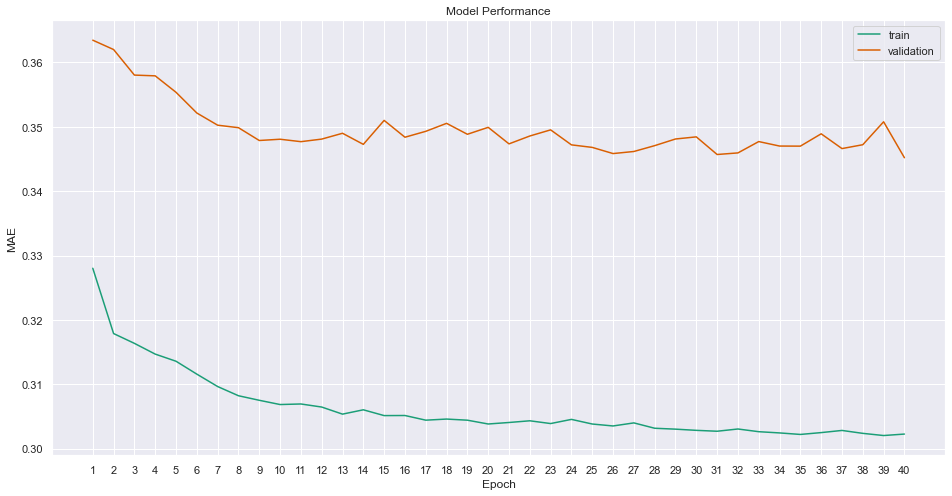

In [62]:
    plt.figure(figsize=(16,8))
    # plot results train and results test using sns
    sns.lineplot(x=range(1,len(results_train)+1), y=results_train, label='Train')
    sns.lineplot(x=range(1,len(results_test)+1), y=results_test, label='Test')
    plt.xticks(np.arange(1, len(results_test)+1 , step = 1))
    plt.title('Model Performance')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [63]:
neural_network_params["verbose"] = 0
neural_network_params["epochs"] = 26
neural_network_model, nn_Y_pred, nn_mae, results_train, results_test = Model.neural_network(df_train_encoded, df_test_encoded, **neural_network_params)
print("Neural_Network MAE on test set:", nn_mae)

Neural_Network MAE on test set: 0.34617401431461875


In [67]:
catboost_encoded, catboost_Y_pred_encoded, catboost_mae_encoded, catboost_Y_pred_proba_encoded = Model.catboost(df_train_encoded,df_test_encoded,catboost_params,0,[])
print("Catboost_encoded MAE on test set:", catboost_mae_encoded)

Catboost_encoded MAE on test set: 0.3344484966832266


In [93]:
lightgbm_encoded, lightgbm_Y_pred_encoded, lightgbm_mae_encoded, lightgbm_Y_pred_proba_encoded = Model.lightgmb(df_train_encoded, df_test_encoded, lightgbm_params, 0,[])
print("Lightgbm_encoded MAE on test set:", lightgbm_mae_encoded)

Lightgbm_encoded MAE on test set: 0.3337449386899463


In [95]:
catboost_encoded_whole, catboost_Y_pred_encoded_whole, catboost_mae_encoded_whole, catboost_Y_pred_proba_encoded_whole = Model.catboost(df_train_encoded_whole,df_test_encoded_whole,catboost_params,1,cat_cols)
print("Catboost_encoded_whole MAE on test set:", catboost_mae_encoded_whole)

0:	learn: 0.6720275	test: 0.6803872	best: 0.6803872 (0)	total: 512ms	remaining: 1m 16s
1:	learn: 0.6531883	test: 0.6678533	best: 0.6678533 (1)	total: 1.02s	remaining: 1m 15s
2:	learn: 0.6386062	test: 0.6582833	best: 0.6582833 (2)	total: 1.67s	remaining: 1m 21s
3:	learn: 0.6264081	test: 0.6499026	best: 0.6499026 (3)	total: 2.19s	remaining: 1m 19s
4:	learn: 0.6171942	test: 0.6438690	best: 0.6438690 (4)	total: 2.7s	remaining: 1m 18s
5:	learn: 0.6087886	test: 0.6373815	best: 0.6373815 (5)	total: 3.2s	remaining: 1m 16s
6:	learn: 0.6025537	test: 0.6331934	best: 0.6331934 (6)	total: 3.64s	remaining: 1m 14s
7:	learn: 0.5975114	test: 0.6299555	best: 0.6299555 (7)	total: 4.2s	remaining: 1m 14s
8:	learn: 0.5925357	test: 0.6267977	best: 0.6267977 (8)	total: 4.68s	remaining: 1m 13s
9:	learn: 0.5883758	test: 0.6234677	best: 0.6234677 (9)	total: 5.13s	remaining: 1m 11s
10:	learn: 0.5851614	test: 0.6218075	best: 0.6218075 (10)	total: 5.64s	remaining: 1m 11s
11:	learn: 0.5827666	test: 0.6203759	best: 0

In [96]:
lightgbm_encoded_whole, lightgbm_Y_pred_encoded_whole, lightgbm_mae_encoded_whole, lightgbm_Y_pred_proba_encoded_whole = Model.lightgmb(df_train_encoded_whole, df_test_encoded_whole, lightgbm_params, 0,cat_cols)
print("Lightgbm_encoded_whole MAE on test set:", lightgbm_mae_encoded_whole)

Lightgbm_encoded_whole MAE on test set: 0.32995434052206873


In [98]:
mae_dict = {
            "Catboost_native":catboost_mae,"Xgboost":xgb_mae,"Lightgbm_native":lightgbm_mae,"Neural_Network":nn_mae, "Catboost_encoded":catboost_mae_encoded,
            "Lightgbm_encoded":lightgbm_mae_encoded,"Catboost_encoded_whole":catboost_mae_encoded_whole,"Lightgbm_encoded_whole":lightgbm_mae_encoded_whole
            }
model_results = pd.DataFrame(mae_dict,index=["MAE_1"]).round(4)
model_results.sort_values(by="MAE_1",ascending=True,inplace=True,axis=1)
model_results.transpose()

,MAE_1
Catboost_native,0.3276
Lightgbm_encoded_whole,0.3300
Lightgbm_native,0.3305
Lightgbm_encoded,0.3337
Catboost_encoded,0.3344
Xgboost,0.3351
Catboost_encoded_whole,0.3353
Neural_Network,0.3462


From the preliminary fitting of the models, we can see that our model's performance is relatively good. **Catboost_native** performed the best with an MAE of 0.327 followed closely by **Lightgbm_encoded_whole** and **Lightgbm_native** with an MAE of 0.33. The **Xgboost model** performed slightly worse with an MAE of 0.335. The **Neural Network** performed the worst with an MAE of 0.346. Since the **Neural Network** performed the worst, we will not use it further and will focus on the other three models and their submodels.  